In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import sys
sys.path.append('../')
import default_style

In [2]:
TS_DATASET_FOLDER = os.path.join('..', 'dataset')
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, 'preprocessed_traces')
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, 'preproc_ts.df')

TARGET = 'statement'
TRACES = 'syllables_02_STFT'

In [3]:
df = pd.read_csv(DF_PREPROC_FILE).drop(columns=['Unnamed: 0'])
df["actor_number"] = df.actor.apply(lambda x: int(x.split("_")[1]))
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,end_s,...,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index,actor_number
0,speech,neutral,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.009833,2.252000,...,[1.9371510e-07 1.2311473e-02 1.1168692e-02 ......,0,1128,2240,3200,4304,5208,5808,7448,1
1,speech,neutral,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.068500,2.294667,...,[3.5017729e-07 2.6198970e-02 2.5683273e-02 ......,0,2008,3208,3880,4224,5112,5800,7352,1
2,speech,neutral,normal,dogs,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.012000,2.238500,...,[2.49594450e-07 1.23483688e-02 1.06786685e-02 ...,0,2816,3352,3912,4296,5232,5880,7352,1
3,speech,neutral,normal,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.008833,2.187167,...,[1.1920929e-07 1.2154780e-02 1.6620707e-02 ......,0,1664,2664,3208,3672,4840,5448,7064,1
4,speech,calm,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.023667,2.534167,...,[1.1920929e-07 2.0026902e-03 7.9688808e-04 ......,0,2088,3584,4832,5800,6944,7560,9056,1


In [4]:
traces_dict = {}
files = os.listdir(TS_PREPROC_FOLDER)

file_path = os.path.join(TS_PREPROC_FOLDER, f"{TRACES}.npy")
traces_dict[TRACES] = np.load(file_path, allow_pickle=True)

In [5]:
traces = traces_dict[TRACES]
# traces = traces.reshape(2452, 729)
traces.shape

(2452, 27, 27)

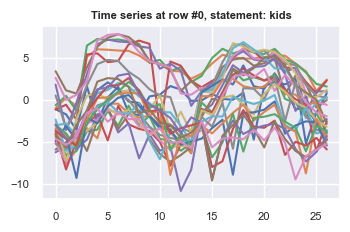

In [6]:
index = 0
statement = df['statement'][index]
plt.plot(traces[index])
plt.title(f'Time series at row #{index}, statement: {statement}')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# Sets tests to be over actor 19 (excluded)
X_test = traces[df.actor_number > 19]
y_test = df[TARGET][df.actor_number > 19].to_numpy()

# Sets the train and validation inside actors < 19
X_train, X_val, y_train, y_val = train_test_split(  traces[df.actor_number <= 19], 
                                                    df[TARGET][df.actor_number <= 19].to_numpy(), 
                                                    test_size=0.2, random_state=100)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1545, 27, 27), (387, 27, 27), (520, 27, 27), (1545,), (387,), (520,))

/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


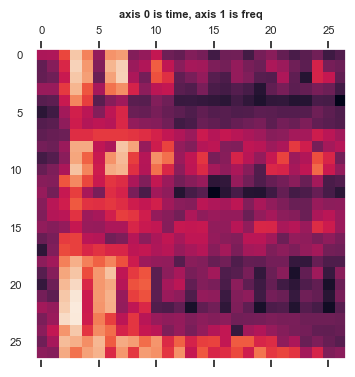

In [9]:
plt.matshow(X_test[0]);plt.grid(ls="")
plt.title("axis 0 is time, axis 1 is freq");

# CNN for statement and syllables 0&2

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

print(y_train[0])

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

print(y_train[0])

dogs
0


In [11]:
import optuna
from keras.layers import BatchNormalization, Activation
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, GlobalAveragePooling1D
from sklearn.metrics import accuracy_score

def build_model(input_shape, n_categories,
                n_conv=0, n_hidden=0, hidden_nodes=32,
                dropout=0.01, filters=8, kernel_size=5, **kwargs):
    
    # Stuff must be given in (timestep, spectral_coeff) format
    n_timesteps = input_shape[0]
    n_features = input_shape[1]

    model = Sequential()

    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     activation='relu',
                     input_shape=(n_timesteps, n_features),
                     name="base_conv"
                     ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    for i in range(n_conv):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Dropout(dropout))

    model.add(GlobalAveragePooling1D())

    for i in range(n_hidden):
        model.add(Dense(hidden_nodes, activation='relu'))

    model.add(Dense(n_categories, activation='softmax'))    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [12]:
# Test to check the accuracy of a "belly" network
test_model = build_model((27,27), 2, 
                         n_conv=2, n_hidden=3, hidden_nodes=256)
test_model.summary()
test_model.fit(X_train, y_train,  verbose=True, epochs=8)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 23, 8)             1088      
                                                                 
 batch_normalization (Batch  (None, 23, 8)             32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 23, 8)             0         
                                                                 
 extra_conv_0 (Conv1D)       (None, 19, 8)             328       
                                                                 
 batch_normalization_1 (Bat  (None, 19, 8)             32        
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 19, 8)             0

In [13]:
# objective function to be minimized
def objective_fun(trial, X, y, validation_X, validation_y):

    n_conv = trial.suggest_int('n_conv', 0, 3)
    n_hidden = trial.suggest_int('n_hidden', 0, 3)
    hidden_nodes = trial.suggest_int('hidden_nodes', 8, 256)
    dropout = trial.suggest_float('dropout', 0, 0.4)
    filters = trial.suggest_int('filters', 2, 16)
    kernel_size = trial.suggest_int('kernel_size', 2, 16)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    epochs = trial.suggest_int('epochs', 5, 90)
    
    print(f"Running little bitch having n_conv={n_conv}, dropout={dropout}, hidden_nodes={hidden_nodes}")
    
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
                        n_hidden=n_hidden,
                        hidden_nodes=hidden_nodes,
                        n_conv=n_conv,
                        dropout=dropout,
                        filters=filters,
                        kernel_size=kernel_size,
                       )

    cnn.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=False)
    
    y_pred = np.argmax(cnn.predict(validation_X), axis=1)

    error = accuracy_score(validation_y, y_pred)

    return error


#study = optuna.create_study(direction='maximize')
#trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
#study.optimize(trial_function, n_trials=150, n_jobs=-1, catch=ValueError)

[I 2023-07-03 17:15:02,243] A new study created in memory with name: no-name-37f4a465-f34a-47fd-89eb-40ee203af5cb


Running little bitch having n_conv=2, dropout=0.34510427993701076, hidden_nodes=98
Running little bitch having n_conv=3, dropout=0.13860775003958503, hidden_nodes=141
Running little bitch having n_conv=0, dropout=0.17452294545861224, hidden_nodes=48
Running little bitch having n_conv=0, dropout=0.22226097631299574, hidden_nodes=192
Running little bitch having n_conv=1, dropout=0.018010877668116265, hidden_nodes=52
Running little bitch having n_conv=0, dropout=0.07444423474909345, hidden_nodes=11
Running little bitch having n_conv=3, dropout=0.2706666251922671, hidden_nodes=85Running little bitch having n_conv=3, dropout=0.36597754675247524, hidden_nodes=107



[W 2023-07-03 17:15:02,390] Trial 1 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 141, 'dropout': 0.13860775003958503, 'filters': 14, 'kernel_size': 10, 'batch_size': 61, 'epochs': 62} because of the following error: ValueError('Exception encountered when calling layer "extra_conv_1" (type Conv1D).\n\nNegative dimension size caused by subtracting 10 from 9 for \'{{node extra_conv_1/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](extra_conv_1/Conv1D/ExpandDims, extra_conv_1/Conv1D/ExpandDims_1)\' with input shapes: [?,1,9,14], [1,10,14,14].\n\nCall arguments received by layer "extra_conv_1" (type Conv1D):\n  • inputs=tf.Tensor(shape=(None, 9, 14), dtype=float32)').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)


Running little bitch having n_conv=0, dropout=0.07755125983995725, hidden_nodes=114
Running little bitch having n_conv=3, dropout=0.003002904193410183, hidden_nodes=24
Running little bitch having n_conv=0, dropout=0.20313545287334583, hidden_nodes=48
Running little bitch having n_conv=1, dropout=0.3836021898505058, hidden_nodes=14
13/13 [==============================] - 0s 2ms/step


[I 2023-07-03 17:15:06,186] Trial 3 finished with value: 0.8552971576227391 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 192, 'dropout': 0.22226097631299574, 'filters': 6, 'kernel_size': 2, 'batch_size': 48, 'epochs': 19}. Best is trial 3 with value: 0.8552971576227391.


Running little bitch having n_conv=1, dropout=0.11704696559407207, hidden_nodes=74
13/13 [==============================] - 0s 2ms/step


[I 2023-07-03 17:15:07,484] Trial 10 finished with value: 0.9844961240310077 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 48, 'dropout': 0.20313545287334583, 'filters': 12, 'kernel_size': 11, 'batch_size': 36, 'epochs': 20}. Best is trial 10 with value: 0.9844961240310077.
[W 2023-07-03 17:15:07,538] Trial 13 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 230, 'dropout': 0.23433606327515816, 'filters': 9, 'kernel_size': 16, 'batch_size': 19, 'epochs': 44} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vw

Running little bitch having n_conv=2, dropout=0.23433606327515816, hidden_nodes=230
Running little bitch having n_conv=1, dropout=0.11668418271192436, hidden_nodes=145
13/13 [==============================] - 0s 6ms/step


[I 2023-07-03 17:15:12,533] Trial 14 finished with value: 0.9844961240310077 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 145, 'dropout': 0.11668418271192436, 'filters': 13, 'kernel_size': 13, 'batch_size': 44, 'epochs': 28}. Best is trial 10 with value: 0.9844961240310077.


Running little bitch having n_conv=0, dropout=0.28588532563457136, hidden_nodes=124
13/13 [==============================] - 0s 3ms/step


[I 2023-07-03 17:15:13,500] Trial 4 finished with value: 0.9896640826873385 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 52, 'dropout': 0.018010877668116265, 'filters': 12, 'kernel_size': 10, 'batch_size': 62, 'epochs': 82}. Best is trial 4 with value: 0.9896640826873385.


Running little bitch having n_conv=2, dropout=0.1436917076904213, hidden_nodes=119
13/13 [==============================] - 0s 2ms/step


[I 2023-07-03 17:15:13,854] Trial 2 finished with value: 0.7700258397932817 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 48, 'dropout': 0.17452294545861224, 'filters': 2, 'kernel_size': 3, 'batch_size': 19, 'epochs': 40}. Best is trial 4 with value: 0.9896640826873385.


Running little bitch having n_conv=0, dropout=0.3674684479239232, hidden_nodes=135
13/13 [==============================] - 0s 3ms/step


[I 2023-07-03 17:15:15,233] Trial 11 finished with value: 0.979328165374677 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 14, 'dropout': 0.3836021898505058, 'filters': 7, 'kernel_size': 9, 'batch_size': 28, 'epochs': 55}. Best is trial 4 with value: 0.9896640826873385.


Running little bitch having n_conv=0, dropout=0.2461876372442863, hidden_nodes=197
13/13 [==============================] - 0s 2ms/step


[I 2023-07-03 17:15:16,115] Trial 5 finished with value: 0.9689922480620154 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 11, 'dropout': 0.07444423474909345, 'filters': 5, 'kernel_size': 11, 'batch_size': 28, 'epochs': 69}. Best is trial 4 with value: 0.9896640826873385.


Running little bitch having n_conv=0, dropout=0.2660563427049148, hidden_nodes=48
13/13 [==============================] - 0s 2ms/step


[I 2023-07-03 17:15:16,565] Trial 9 finished with value: 0.9715762273901809 and parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 24, 'dropout': 0.003002904193410183, 'filters': 7, 'kernel_size': 6, 'batch_size': 38, 'epochs': 53}. Best is trial 4 with value: 0.9896640826873385.


Running little bitch having n_conv=0, dropout=0.25458510408628227, hidden_nodes=164
13/13 [==============================] - 0s 2ms/step


[I 2023-07-03 17:15:18,706] Trial 18 finished with value: 0.9819121447028424 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 197, 'dropout': 0.2461876372442863, 'filters': 7, 'kernel_size': 11, 'batch_size': 26, 'epochs': 16}. Best is trial 4 with value: 0.9896640826873385.


Running little bitch having n_conv=1, dropout=0.2620664253269834, hidden_nodes=50
13/13 [==============================] - 0s 5ms/step


[I 2023-07-03 17:15:19,726] Trial 8 finished with value: 0.8501291989664083 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 114, 'dropout': 0.07755125983995725, 'filters': 8, 'kernel_size': 2, 'batch_size': 19, 'epochs': 56}. Best is trial 4 with value: 0.9896640826873385.


Running little bitch having n_conv=3, dropout=0.0022927421309092977, hidden_nodes=99


[W 2023-07-03 17:15:19,822] Trial 22 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 99, 'dropout': 0.0022927421309092977, 'filters': 11, 'kernel_size': 16, 'batch_size': 64, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cn

Running little bitch having n_conv=3, dropout=0.006943677780692645, hidden_nodes=96


[W 2023-07-03 17:15:20,048] Trial 24 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 96, 'dropout': 0.018337055085262566, 'filters': 16, 'kernel_size': 16, 'batch_size': 61, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn

Running little bitch having n_conv=3, dropout=0.018337055085262566, hidden_nodes=96
Running little bitch having n_conv=3, dropout=0.028020308404582424, hidden_nodes=256


[W 2023-07-03 17:15:20,228] Trial 25 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 256, 'dropout': 0.028020308404582424, 'filters': 16, 'kernel_size': 16, 'batch_size': 64, 'epochs': 87} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cn

Running little bitch having n_conv=3, dropout=0.0034368146648093394, hidden_nodes=254
 1/13 [=>............................] - ETA: 0s

[W 2023-07-03 17:15:20,327] Trial 26 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 254, 'dropout': 0.0034368146648093394, 'filters': 16, 'kernel_size': 16, 'batch_size': 64, 'epochs': 85} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    c

Running little bitch having n_conv=3, dropout=0.009219015785568555, hidden_nodes=253
13/13 [==============================] - 0s 5ms/step


[W 2023-07-03 17:15:20,411] Trial 27 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 253, 'dropout': 0.009219015785568555, 'filters': 16, 'kernel_size': 16, 'batch_size': 64, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cn

Running little bitch having n_conv=3, dropout=0.02131775614845808, hidden_nodes=252


[W 2023-07-03 17:15:20,508] Trial 28 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 252, 'dropout': 0.02131775614845808, 'filters': 16, 'kernel_size': 16, 'batch_size': 61, 'epochs': 86} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn

Running little bitch having n_conv=2, dropout=0.15785484882676276, hidden_nodes=81
Running little bitch having n_conv=2, dropout=0.16315046119468452, hidden_nodes=73


[W 2023-07-03 17:15:20,584] Trial 29 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 81, 'dropout': 0.15785484882676276, 'filters': 13, 'kernel_size': 16, 'batch_size': 58, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn 

Running little bitch having n_conv=2, dropout=0.008022695805400604, hidden_nodes=73


[W 2023-07-03 17:15:20,666] Trial 30 failed with value None.


Running little bitch having n_conv=2, dropout=0.007700981629023777, hidden_nodes=74


[W 2023-07-03 17:15:20,720] Trial 31 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 73, 'dropout': 0.008022695805400604, 'filters': 13, 'kernel_size': 15, 'batch_size': 64, 'epochs': 87} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn

Running little bitch having n_conv=2, dropout=0.003099572409242496, hidden_nodes=74
Running little bitch having n_conv=2, dropout=0.0018344934856974748, hidden_nodes=74


[W 2023-07-03 17:15:20,875] Trial 33 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 74, 'dropout': 0.003099572409242496, 'filters': 13, 'kernel_size': 16, 'batch_size': 63, 'epochs': 87} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn

Running little bitch having n_conv=2, dropout=0.0013411896513015192, hidden_nodes=77
Running little bitch having n_conv=2, dropout=0.0015284929747953861, hidden_nodes=75


[W 2023-07-03 17:15:21,022] Trial 36 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 77, 'dropout': 0.0013411896513015192, 'filters': 13, 'kernel_size': 16, 'batch_size': 64, 'epochs': 86} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cn

Running little bitch having n_conv=2, dropout=0.001040795573098434, hidden_nodes=77
Running little bitch having n_conv=2, dropout=0.15553414238175411, hidden_nodes=76


[W 2023-07-03 17:15:21,156] Trial 37 failed with value None.
[W 2023-07-03 17:15:21,171] Trial 38 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 76, 'dropout': 0.15553414238175411, 'filters': 13, 'kernel_size': 16, 'batch_size': 61, 'epochs': 87} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipyk

Running little bitch having n_conv=2, dropout=0.002321287800240438, hidden_nodes=75
Running little bitch having n_conv=2, dropout=0.16237323656691538, hidden_nodes=79


[W 2023-07-03 17:15:21,305] Trial 39 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 75, 'dropout': 0.002321287800240438, 'filters': 13, 'kernel_size': 14, 'batch_size': 63, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn 

Running little bitch having n_conv=2, dropout=0.1535066432760285, hidden_nodes=78
Running little bitch having n_conv=2, dropout=0.15530850250065178, hidden_nodes=69


[W 2023-07-03 17:15:21,409] Trial 41 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 78, 'dropout': 0.1535066432760285, 'filters': 13, 'kernel_size': 16, 'batch_size': 63, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn =

Running little bitch having n_conv=2, dropout=0.16040751302707493, hidden_nodes=82
Running little bitch having n_conv=2, dropout=0.0027360160438041903, hidden_nodes=76


[W 2023-07-03 17:15:21,557] Trial 43 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 82, 'dropout': 0.16040751302707493, 'filters': 13, 'kernel_size': 16, 'batch_size': 64, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn 

Running little bitch having n_conv=2, dropout=0.14945819350863276, hidden_nodes=84
Running little bitch having n_conv=2, dropout=0.14711616197897914, hidden_nodes=74
 1/13 [=>............................] - ETA: 0s

[W 2023-07-03 17:15:21,722] Trial 45 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 84, 'dropout': 0.14945819350863276, 'filters': 13, 'kernel_size': 15, 'batch_size': 57, 'epochs': 87} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn 

 9/13 [===================>..........] - ETA: 0sRunning little bitch having n_conv=2, dropout=8.333095970494697e-05, hidden_nodes=72


[W 2023-07-03 17:15:21,787] Trial 46 failed with value None.


13/13 [==============================] - 0s 7ms/step


[W 2023-07-03 17:15:21,854] Trial 47 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 72, 'dropout': 8.333095970494697e-05, 'filters': 13, 'kernel_size': 16, 'batch_size': 63, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cn

Running little bitch having n_conv=2, dropout=0.1786093967645457, hidden_nodes=71
Running little bitch having n_conv=2, dropout=0.0008418344478484038, hidden_nodes=73
Running little bitch having n_conv=2, dropout=0.14628679534438244, hidden_nodes=76

[W 2023-07-03 17:15:21,984] Trial 48 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 71, 'dropout': 0.1786093967645457, 'filters': 13, 'kernel_size': 16, 'batch_size': 62, 'epochs': 85} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn =

[W 2023-07-03 17:15:22,006] Trial 49 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 73, 'dropout': 0.0008418344478484038, 'filters': 13, 'kernel_size': 15, 'batch_size': 64, 'epochs': 84} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cn

Running little bitch having n_conv=2, dropout=0.15878668667124193, hidden_nodes=77
Running little bitch having n_conv=2, dropout=0.145846459170275, hidden_nodes=74


[W 2023-07-03 17:15:22,172] Trial 51 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 77, 'dropout': 0.15878668667124193, 'filters': 13, 'kernel_size': 15, 'batch_size': 63, 'epochs': 87} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn 

Running little bitch having n_conv=2, dropout=0.15651949777770305, hidden_nodes=77
Running little bitch having n_conv=2, dropout=0.16126210858909668, hidden_nodes=78


[W 2023-07-03 17:15:22,307] Trial 53 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 77, 'dropout': 0.15651949777770305, 'filters': 13, 'kernel_size': 16, 'batch_size': 64, 'epochs': 86} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn 

Running little bitch having n_conv=2, dropout=0.17067854279737113, hidden_nodes=74
Running little bitch having n_conv=2, dropout=0.16854672849497962, hidden_nodes=76


[W 2023-07-03 17:15:22,406] Trial 54 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 78, 'dropout': 0.16126210858909668, 'filters': 13, 'kernel_size': 13, 'batch_size': 64, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn =

Running little bitch having n_conv=2, dropout=0.16079017710245658, hidden_nodes=73
Running little bitch having n_conv=2, dropout=0.1604824485743201, hidden_nodes=75


[W 2023-07-03 17:15:22,518] Trial 57 failed with value None.
[W 2023-07-03 17:15:22,605] Trial 58 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 75, 'dropout': 0.1604824485743201, 'filters': 13, 'kernel_size': 16, 'batch_size': 64, 'epochs': 80} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipyke

Running little bitch having n_conv=2, dropout=0.16156153393343023, hidden_nodes=76
Running little bitch having n_conv=2, dropout=0.1307560774570054, hidden_nodes=67


[W 2023-07-03 17:15:22,632] Trial 58 failed with value None.
[W 2023-07-03 17:15:22,641] Trial 59 failed with value None.
[W 2023-07-03 17:15:22,904] Trial 62 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 79, 'dropout': 0.15810833513102723, 'filters': 13, 'kernel_size': 16, 'batch_size': 64, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)


Running little bitch having n_conv=2, dropout=0.0026958738260426107, hidden_nodes=80
Running little bitch having n_conv=2, dropout=0.15810833513102723, hidden_nodes=79
Running little bitch having n_conv=2, dropout=0.16088559272979397, hidden_nodes=83
Running little bitch having n_conv=2, dropout=0.0028429994969143193, hidden_nodes=75


[W 2023-07-03 17:15:23,053] Trial 64 failed with value None.
[W 2023-07-03 17:15:23,048] Trial 63 failed with value None.
[W 2023-07-03 17:15:23,157] Trial 65 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 76, 'dropout': 0.1354276585386024, 'filters': 13, 'kernel_size': 16, 'batch_size': 62, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
 

Running little bitch having n_conv=2, dropout=0.1354276585386024, hidden_nodes=76
Running little bitch having n_conv=2, dropout=0.16977588184100356, hidden_nodes=72
Running little bitch having n_conv=2, dropout=0.15736673925424133, hidden_nodes=70


[W 2023-07-03 17:15:23,301] Trial 67 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 70, 'dropout': 0.15736673925424133, 'filters': 13, 'kernel_size': 16, 'batch_size': 64, 'epochs': 87} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn 

Running little bitch having n_conv=2, dropout=0.14724385122705372, hidden_nodes=79
Running little bitch having n_conv=2, dropout=0.14073866675189686, hidden_nodes=77
Running little bitch having n_conv=2, dropout=0.16572049919038262, hidden_nodes=75
Running little bitch having n_conv=2, dropout=0.15497281101805457, hidden_nodes=64


[W 2023-07-03 17:15:23,567] Trial 71 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 64, 'dropout': 0.15497281101805457, 'filters': 13, 'kernel_size': 16, 'batch_size': 64, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn 

Running little bitch having n_conv=2, dropout=0.16292044270935627, hidden_nodes=68
Running little bitch having n_conv=2, dropout=0.0002851542898405432, hidden_nodes=80
Running little bitch having n_conv=2, dropout=0.002377708438428605, hidden_nodes=78
Running little bitch having n_conv=2, dropout=0.15108590256211493, hidden_nodes=78


[W 2023-07-03 17:15:23,731] Trial 74 failed with value None.
[W 2023-07-03 17:15:23,797] Trial 75 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 78, 'dropout': 0.15108590256211493, 'filters': 13, 'kernel_size': 15, 'batch_size': 61, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipyk

Running little bitch having n_conv=2, dropout=0.0010871944847998805, hidden_nodes=75
Running little bitch having n_conv=2, dropout=0.16178842479557365, hidden_nodes=76
Running little bitch having n_conv=2, dropout=0.15870087933121588, hidden_nodes=70
Running little bitch having n_conv=2, dropout=0.15127620754565935, hidden_nodes=77


[W 2023-07-03 17:15:23,937] Trial 79 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 77, 'dropout': 0.15127620754565935, 'filters': 13, 'kernel_size': 15, 'batch_size': 63, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn 

Running little bitch having n_conv=2, dropout=0.15643600315503792, hidden_nodes=75
Running little bitch having n_conv=2, dropout=0.1655383828211282, hidden_nodes=85
Running little bitch having n_conv=2, dropout=0.17052079247285198, hidden_nodes=71
Running little bitch having n_conv=2, dropout=0.16632363826844018, hidden_nodes=74


[W 2023-07-03 17:15:24,135] Trial 82 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 71, 'dropout': 0.17052079247285198, 'filters': 13, 'kernel_size': 15, 'batch_size': 61, 'epochs': 83} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn 

Running little bitch having n_conv=2, dropout=0.1881307452157325, hidden_nodes=83
Running little bitch having n_conv=2, dropout=0.16227080882611186, hidden_nodes=76
Running little bitch having n_conv=2, dropout=0.15793009674966926, hidden_nodes=80
Running little bitch having n_conv=2, dropout=0.00202061248769847, hidden_nodes=69


[W 2023-07-03 17:15:24,402] Trial 87 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 69, 'dropout': 0.00202061248769847, 'filters': 13, 'kernel_size': 15, 'batch_size': 64, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn 

Running little bitch having n_conv=2, dropout=0.001211333400609492, hidden_nodes=76
Running little bitch having n_conv=2, dropout=0.16037734584955296, hidden_nodes=74
Running little bitch having n_conv=2, dropout=0.1695657166537391, hidden_nodes=85
Running little bitch having n_conv=2, dropout=0.1612551760357979, hidden_nodes=75
Running little bitch having n_conv=2, dropout=0.0007046604088304757, hidden_nodes=85


[W 2023-07-03 17:15:24,621] Trial 91 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 75, 'dropout': 0.1612551760357979, 'filters': 13, 'kernel_size': 16, 'batch_size': 63, 'epochs': 85} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn =

Running little bitch having n_conv=2, dropout=0.15991064214371897, hidden_nodes=81
Running little bitch having n_conv=2, dropout=0.1488848702540138, hidden_nodes=65
Running little bitch having n_conv=2, dropout=0.1636202376811509, hidden_nodes=78
Running little bitch having n_conv=2, dropout=0.002233623383981115, hidden_nodes=75


[W 2023-07-03 17:15:24,877] Trial 96 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 75, 'dropout': 0.002233623383981115, 'filters': 13, 'kernel_size': 16, 'batch_size': 64, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn

Running little bitch having n_conv=2, dropout=0.1778635098850739, hidden_nodes=81
Running little bitch having n_conv=2, dropout=0.1556335994764244, hidden_nodes=70
Running little bitch having n_conv=2, dropout=0.15672975742609607, hidden_nodes=69
Running little bitch having n_conv=2, dropout=0.17172677438735057, hidden_nodes=70
Running little bitch having n_conv=2, dropout=0.16552380254085008, hidden_nodes=78


[W 2023-07-03 17:15:25,127] Trial 100 failed with value None.
[W 2023-07-03 17:15:25,197] Trial 101 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 78, 'dropout': 0.16552380254085008, 'filters': 13, 'kernel_size': 16, 'batch_size': 64, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ip

Running little bitch having n_conv=2, dropout=0.1642424888744655, hidden_nodes=82
Running little bitch having n_conv=2, dropout=0.18045027218159523, hidden_nodes=77
Running little bitch having n_conv=2, dropout=0.00019551035769621583, hidden_nodes=73
Running little bitch having n_conv=2, dropout=0.16250128951281645, hidden_nodes=79
Running little bitch having n_conv=2, dropout=0.16908163327224499, hidden_nodes=71


[W 2023-07-03 17:15:25,419] Trial 105 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 79, 'dropout': 0.16250128951281645, 'filters': 13, 'kernel_size': 15, 'batch_size': 63, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn

Running little bitch having n_conv=2, dropout=0.16269431862427075, hidden_nodes=72
Running little bitch having n_conv=2, dropout=0.16278644967655156, hidden_nodes=77
Running little bitch having n_conv=2, dropout=0.003155474704660627, hidden_nodes=74
Running little bitch having n_conv=2, dropout=0.16844571513205267, hidden_nodes=77


[W 2023-07-03 17:15:25,620] Trial 109 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 74, 'dropout': 0.003155474704660627, 'filters': 13, 'kernel_size': 15, 'batch_size': 63, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cn

Running little bitch having n_conv=2, dropout=0.1509767959983006, hidden_nodes=73
Running little bitch having n_conv=2, dropout=0.0021365024498023154, hidden_nodes=74
Running little bitch having n_conv=2, dropout=0.006474086402080538, hidden_nodes=73
Running little bitch having n_conv=2, dropout=0.146934660776289, hidden_nodes=81
Running little bitch having n_conv=2, dropout=0.15630627666567018, hidden_nodes=67


[W 2023-07-03 17:15:25,909] Trial 114 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 81, 'dropout': 0.146934660776289, 'filters': 13, 'kernel_size': 15, 'batch_size': 62, 'epochs': 87} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn =

Running little bitch having n_conv=2, dropout=0.14836953796313238, hidden_nodes=72
Running little bitch having n_conv=2, dropout=0.15868313101162482, hidden_nodes=79
Running little bitch having n_conv=2, dropout=0.160046532772936, hidden_nodes=84
Running little bitch having n_conv=2, dropout=0.1607634740157785, hidden_nodes=77


[W 2023-07-03 17:15:26,118] Trial 118 failed with value None.
[W 2023-07-03 17:15:26,128] Trial 117 failed with value None.
[W 2023-07-03 17:15:26,145] Trial 119 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 77, 'dropout': 0.1607634740157785, 'filters': 13, 'kernel_size': 16, 'batch_size': 62, 'epochs': 7} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)

Running little bitch having n_conv=2, dropout=0.1624519017885207, hidden_nodes=76
Running little bitch having n_conv=2, dropout=0.1632442570335569, hidden_nodes=77


[W 2023-07-03 17:15:26,428] Trial 120 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 76, 'dropout': 0.1624519017885207, 'filters': 13, 'kernel_size': 15, 'batch_size': 59, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn 

Running little bitch having n_conv=2, dropout=0.0014979660205531459, hidden_nodes=80
Running little bitch having n_conv=2, dropout=0.15778853849396396, hidden_nodes=76
Running little bitch having n_conv=2, dropout=0.1553207414590175, hidden_nodes=80
Running little bitch having n_conv=2, dropout=0.16251456064066006, hidden_nodes=72


[W 2023-07-03 17:15:26,691] Trial 125 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 72, 'dropout': 0.16251456064066006, 'filters': 13, 'kernel_size': 16, 'batch_size': 63, 'epochs': 86} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn

Running little bitch having n_conv=2, dropout=0.008311751581778956, hidden_nodes=74
Running little bitch having n_conv=2, dropout=0.17021608359996515, hidden_nodes=72
Running little bitch having n_conv=2, dropout=0.14085266690416565, hidden_nodes=76
Running little bitch having n_conv=2, dropout=0.16091466567572166, hidden_nodes=75


[W 2023-07-03 17:15:26,826] Trial 129 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 76, 'dropout': 0.14085266690416565, 'filters': 13, 'kernel_size': 15, 'batch_size': 64, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn

Running little bitch having n_conv=2, dropout=0.16548354263421317, hidden_nodes=76
Running little bitch having n_conv=2, dropout=0.001094038830904115, hidden_nodes=74
Running little bitch having n_conv=2, dropout=0.003234058146171068, hidden_nodes=75
 1/13 [=>............................] - ETA: 1s

[W 2023-07-03 17:15:27,059] Trial 130 failed with value None.
[W 2023-07-03 17:15:27,067] Trial 132 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 74, 'dropout': 0.001094038830904115, 'filters': 13, 'kernel_size': 16, 'batch_size': 58, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/i

13/13 [==============================] - 0s 8ms/step
Running little bitch having n_conv=2, dropout=0.0017625426212522777, hidden_nodes=76


[W 2023-07-03 17:15:27,174] Trial 131 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 75, 'dropout': 0.003234058146171068, 'filters': 13, 'kernel_size': 15, 'batch_size': 64, 'epochs': 84} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cn

Running little bitch having n_conv=2, dropout=0.15533407449648443, hidden_nodes=75
Running little bitch having n_conv=2, dropout=0.15879462429668545, hidden_nodes=82
Running little bitch having n_conv=2, dropout=0.13727273583702548, hidden_nodes=81


[W 2023-07-03 17:15:27,326] Trial 133 failed with value None.


Running little bitch having n_conv=2, dropout=0.16644956694832952, hidden_nodes=86


[W 2023-07-03 17:15:27,418] Trial 137 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 81, 'dropout': 0.13727273583702548, 'filters': 11, 'kernel_size': 16, 'batch_size': 56, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn

Running little bitch having n_conv=2, dropout=0.0005299236078926128, hidden_nodes=76
Running little bitch having n_conv=2, dropout=0.16471918459803114, hidden_nodes=85


[W 2023-07-03 17:15:27,570] Trial 138 failed with value None.
[W 2023-07-03 17:15:27,596] Trial 139 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 85, 'dropout': 0.16471918459803114, 'filters': 11, 'kernel_size': 16, 'batch_size': 58, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ip

Running little bitch having n_conv=2, dropout=0.1676603852495546, hidden_nodes=83
Running little bitch having n_conv=2, dropout=0.00010001624358877206, hidden_nodes=83


[W 2023-07-03 17:15:27,633] Trial 139 failed with value None.
[W 2023-07-03 17:15:27,687] Trial 140 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 83, 'dropout': 0.1676603852495546, 'filters': 11, 'kernel_size': 16, 'batch_size': 55, 'epochs': 87} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipy

Running little bitch having n_conv=2, dropout=0.16935865988805202, hidden_nodes=89
Running little bitch having n_conv=2, dropout=0.16139718555514215, hidden_nodes=87
Running little bitch having n_conv=2, dropout=0.17202777043612785, hidden_nodes=87


[W 2023-07-03 17:15:27,805] Trial 142 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 89, 'dropout': 0.16935865988805202, 'filters': 11, 'kernel_size': 14, 'batch_size': 55, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn 

Running little bitch having n_conv=2, dropout=0.16432675185123996, hidden_nodes=81


[W 2023-07-03 17:15:27,886] Trial 144 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 87, 'dropout': 0.17202777043612785, 'filters': 11, 'kernel_size': 16, 'batch_size': 56, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn

Running little bitch having n_conv=2, dropout=0.162730271218894, hidden_nodes=88
Running little bitch having n_conv=2, dropout=0.13199533870865143, hidden_nodes=86
Running little bitch having n_conv=2, dropout=0.14347421468944738, hidden_nodes=82


[W 2023-07-03 17:15:28,003] Trial 147 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 86, 'dropout': 0.13199533870865143, 'filters': 11, 'kernel_size': 16, 'batch_size': 55, 'epochs': 84} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn

Running little bitch having n_conv=2, dropout=0.17013319722054943, hidden_nodes=85


[W 2023-07-03 17:15:28,109] Trial 148 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 85, 'dropout': 0.17013319722054943, 'filters': 11, 'kernel_size': 16, 'batch_size': 55, 'epochs': 10} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train, X_val, y_val)
  File "/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_57426/943726239.py", line 15, in objective_fun
    cnn

13/13 [==============================] - 0s 866us/step


[I 2023-07-03 17:15:28,557] Trial 17 finished with value: 0.8708010335917312 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 135, 'dropout': 0.3674684479239232, 'filters': 2, 'kernel_size': 6, 'batch_size': 44, 'epochs': 67}. Best is trial 4 with value: 0.9896640826873385.


13/13 [==============================] - 0s 1ms/step


[I 2023-07-03 17:15:29,046] Trial 12 finished with value: 0.9741602067183462 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 74, 'dropout': 0.11704696559407207, 'filters': 10, 'kernel_size': 8, 'batch_size': 16, 'epochs': 51}. Best is trial 4 with value: 0.9896640826873385.


13/13 [==============================] - 0s 822us/step


[I 2023-07-03 17:15:30,607] Trial 16 finished with value: 0.9819121447028424 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 119, 'dropout': 0.1436917076904213, 'filters': 14, 'kernel_size': 5, 'batch_size': 51, 'epochs': 78}. Best is trial 4 with value: 0.9896640826873385.


13/13 [==============================] - 0s 679us/step


[I 2023-07-03 17:15:34,311] Trial 21 finished with value: 0.979328165374677 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 50, 'dropout': 0.2620664253269834, 'filters': 11, 'kernel_size': 9, 'batch_size': 20, 'epochs': 75}. Best is trial 4 with value: 0.9896640826873385.


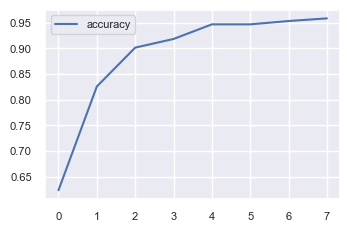

In [14]:
plt.plot(test_model.history.history["accuracy"], label="accuracy")
plt.legend()

In [15]:
#best_params = study.best_params
best_params = {'n_conv': 1,
               'n_hidden': 2,
               'hidden_nodes': 52,
               'dropout': 0.018010877668116265,
               'filters': 12,
               'kernel_size': 10,
               'batch_size': 62,
               'epochs': 82}
best_params

{'n_conv': 1,
 'n_hidden': 2,
 'hidden_nodes': 52,
 'dropout': 0.018010877668116265,
 'filters': 12,
 'kernel_size': 10,
 'batch_size': 62,
 'epochs': 82}

In [16]:
cnn = build_model((27,27), 2, **best_params)
cnn.summary()
cnn.fit( np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), 
            epochs=best_params["epochs"], 
            batch_size=best_params["batch_size"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 18, 12)            3252      
                                                                 
 batch_normalization_3 (Bat  (None, 18, 12)            48        
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 18, 12)            0         
                                                                 
 extra_conv_0 (Conv1D)       (None, 9, 12)             1452      
                                                                 
 batch_normalization_4 (Bat  (None, 9, 12)             48        
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 9, 12)            

In [17]:
from sklearn.metrics import f1_score, classification_report, cohen_kappa_score

y_pred = np.argmax(cnn.predict(X_test), axis=1)

print(f'Cohen k {cohen_kappa_score(y_test, y_pred)}')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

17/17 [==============================] - 0s 579us/step
Cohen k 0.9423076923076923
Accuracy 0.9711538461538461
F1-score [0.97131931 0.97098646]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       260
           1       0.98      0.97      0.97       260

    accuracy                           0.97       520
   macro avg       0.97      0.97      0.97       520
weighted avg       0.97      0.97      0.97       520



   # LIME Explainer 

## setting the classifier for explain_instance using the cnn

In [18]:
from lime import lime_image
from PIL import Image
from skimage.segmentation import mark_boundaries


In [19]:
#To plot the heatmap
rgb_traces = []

for i in range(len(X_test)):
    trace = X_test[i].reshape(27,27)
    
    min_value = np.min(trace)
    max_value = np.max(trace)
    matrice_normalizzata = (trace - min_value) / (max_value - min_value)

    # Crea una matrice 27x27x3 con valori dei canali di colore basati sulla matrice normalizzata
    rosso = matrice_normalizzata
    verde = np.zeros_like(matrice_normalizzata)
    blu = np.zeros_like(matrice_normalizzata)
    heatmap = np.dstack((rosso, verde, blu))
    rgb_traces.append(heatmap)

rgb_traces = np.array([np.array(trace) for trace in rgb_traces])

In [20]:
explainer = lime_image.LimeImageExplainer()

In [21]:
import skimage
from skimage.color import gray2rgb, rgb2gray

def make_prediction(color_img):
    gray_img = rgb2gray(color_img).reshape(-1,27,27)
    preds = cnn.predict(gray_img)
    return preds

In [22]:
#Search for images that aren't full classified
indexes = []

for idx in range(80):
    pred = np.argmax(cnn.predict(X_test[idx].reshape(-1, 27, 27)))

    explanation = explainer.explain_instance(gray2rgb(X_test[idx]), classifier_fn=make_prediction, num_samples=50)
    temp, mask = explanation.get_image_and_mask(pred, num_features=10, hide_rest=False)

    if (not np.all(mask == 0)) & (not np.all(mask == 1)):
        print("Prediction: ", pred)
        print(f"Actual: {y_test[idx]} \tindex: {idx}")
        indexes.append(idx)

explained = pd.DataFrame()
explained['Index'] = indexes
explained['Prediction'] = np.argmax(cnn.predict(X_test[indexes].reshape(-len(indexes), 27, 27)), axis=1)
explained['Actual'] = y_test[indexes]

1/1 [==============================] - 0s 7ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step
Prediction:  1
Actual: 1 	index: 4
1/1 [==============================] - 0s 14ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 8ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step
Prediction:  0
Actual: 0 	index: 14
1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 8ms/step
Prediction:  0
Actual: 0 	index: 19
1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 8ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step
Prediction:  0
Actual: 0 	index: 27
1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 8ms/step
Prediction:  0
Actual: 0 	index: 31
1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step
Prediction:  1
Actual: 1 	index: 36
1/1 [==============================] - 0s 8ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step
Prediction:  0
Actual: 0 	index: 38
1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 8ms/step
Prediction:  1
Actual: 1 	index: 44
1/1 [==============================] - 0s 8ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step
Prediction:  1
Actual: 1 	index: 45
1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step
Prediction:  0
Actual: 0 	index: 62
1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step
Prediction:  1
Actual: 1 	index: 65
1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step
Prediction:  0
Actual: 0 	index: 67
1/1 [==============================] - 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 7ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


In [23]:
explained

,Index,Prediction,Actual
0,4,1,1
1,14,0,0
2,19,0,0
3,27,0,0
4,31,0,0
5,36,1,1
6,38,0,0
7,44,1,1
8,45,1,1
9,62,0,0


In [24]:
idx = 0 #choose the index between 0 and len(indexes)
explanation = explainer.explain_instance(gray2rgb(X_test[indexes[idx]]), classifier_fn=make_prediction, num_samples=50)
temp, mask = explanation.get_image_and_mask(y_test[indexes[idx]], num_features=10, hide_rest=False)

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


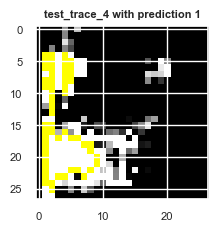

In [25]:
marked_image = mark_boundaries(temp , mask)
plt.title(f'test_trace_{indexes[idx]} with prediction {explained["Prediction"][idx]}')
plt.imshow(marked_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'LIME Explanation')

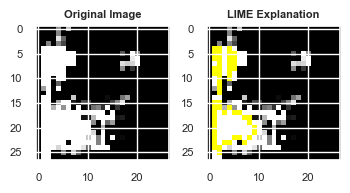

In [26]:
plt.subplot(1,2, 1)
plt.imshow(gray2rgb(X_test[indexes[0]]), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(marked_image)
plt.title('LIME Explanation')

In [27]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

def plot_comparison(main_image, image, mask):
    fig = plt.figure(figsize=(15,5))

    ax = fig.add_subplot(141)
    ax.imshow(main_image, cmap="gray")
    ax.set_title("Original Image")
    ax = fig.add_subplot(142)
    ax.imshow(image)
    ax.set_title("Image")
    ax = fig.add_subplot(143)
    ax.imshow(mask)
    ax.set_title("Mask")
    ax = fig.add_subplot(144)
    ax.imshow(marked_image)
    ax.set_title("Image+Mask Combined")

    plt.show()

1/1 [==============================] - 0s 8ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step
Predicted: kids talk
Actual: kids talk
Emotion: sad
Emotional Intensity: normal
Sex: M


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


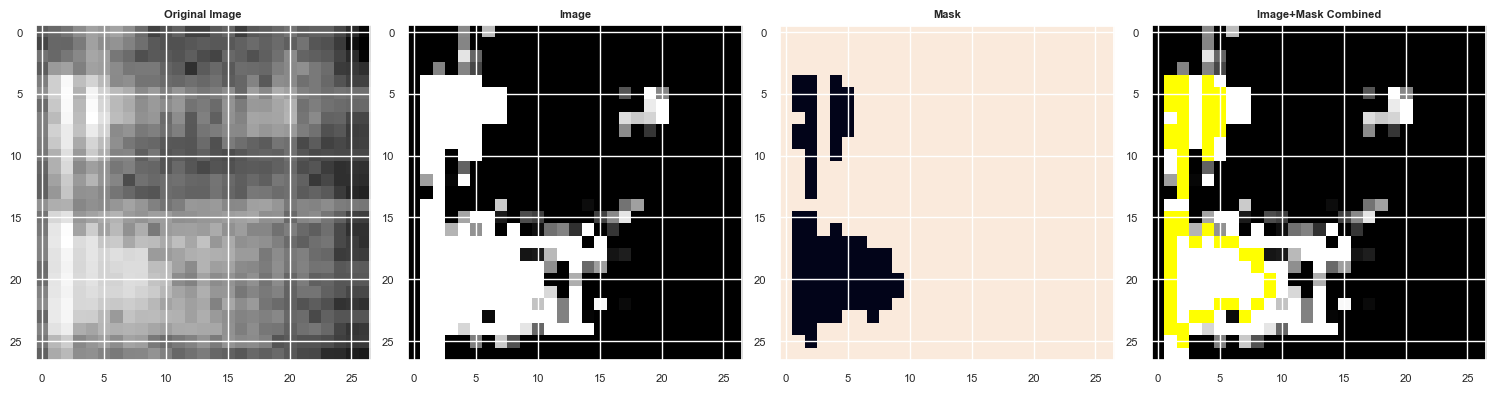

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: dogs sit
Actual: dogs sit
Emotion: angry
Emotional Intensity: normal
Sex: M


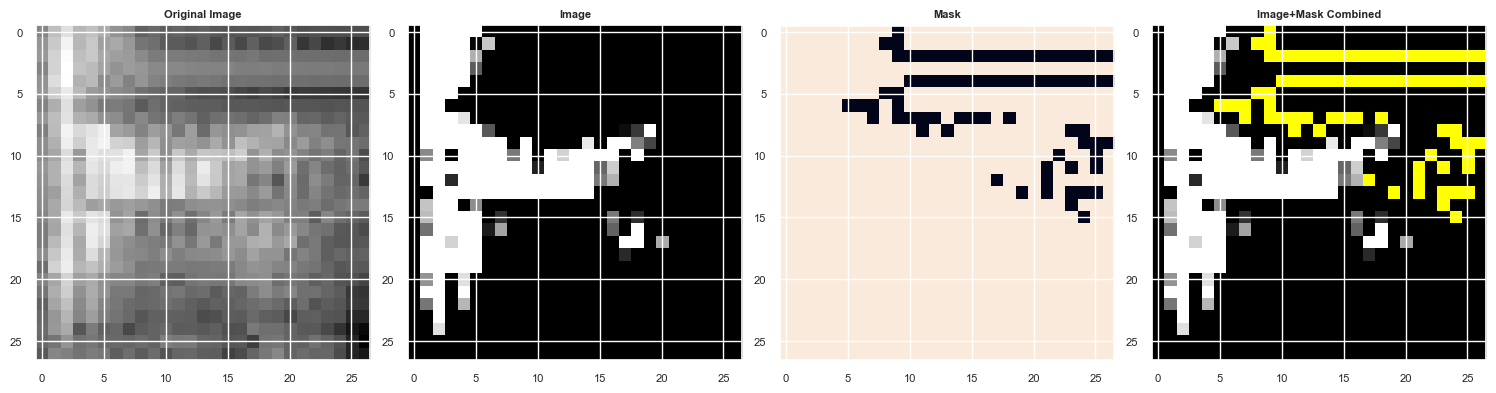

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step
Predicted: dogs sit
Actual: dogs sit
Emotion: fearful
Emotional Intensity: normal
Sex: M


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


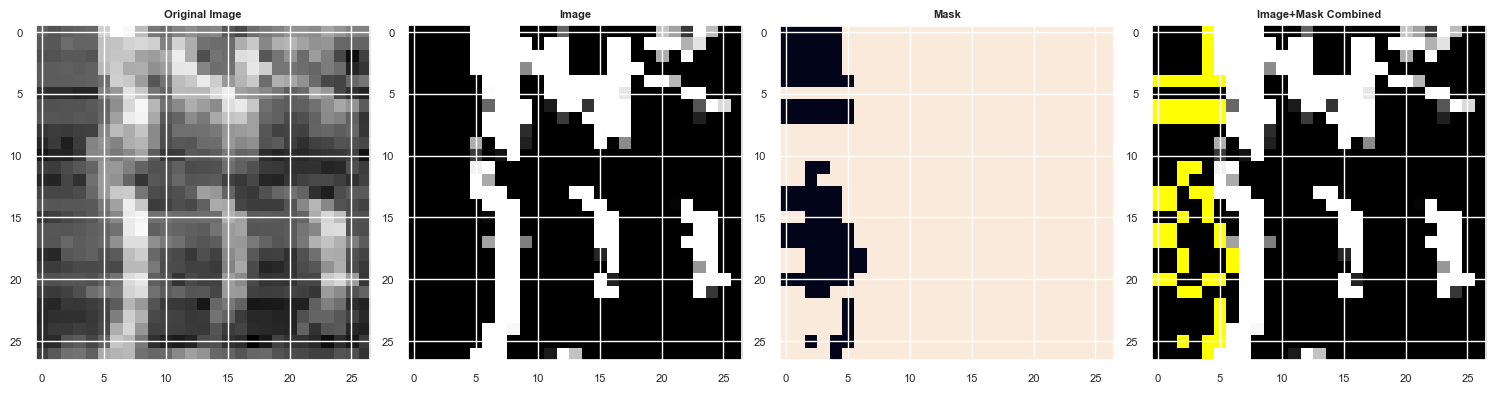

1/1 [==============================] - 0s 14ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step
Predicted: dogs sit
Actual: dogs sit
Emotion: neutral
Emotional Intensity: normal
Sex: F


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


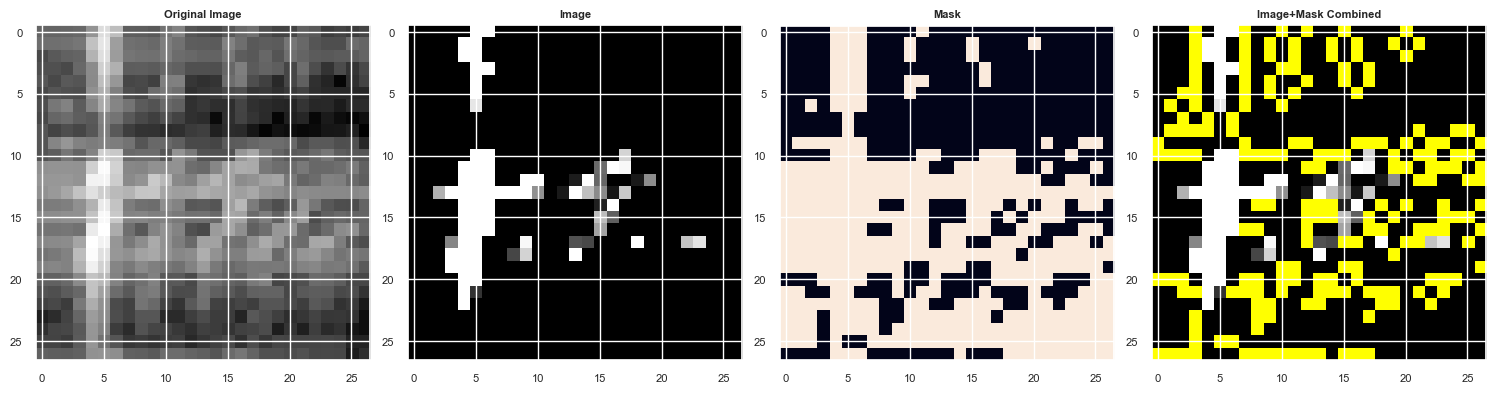

1/1 [==============================] - 0s 8ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: dogs sit
Actual: dogs sit
Emotion: calm
Emotional Intensity: normal
Sex: F


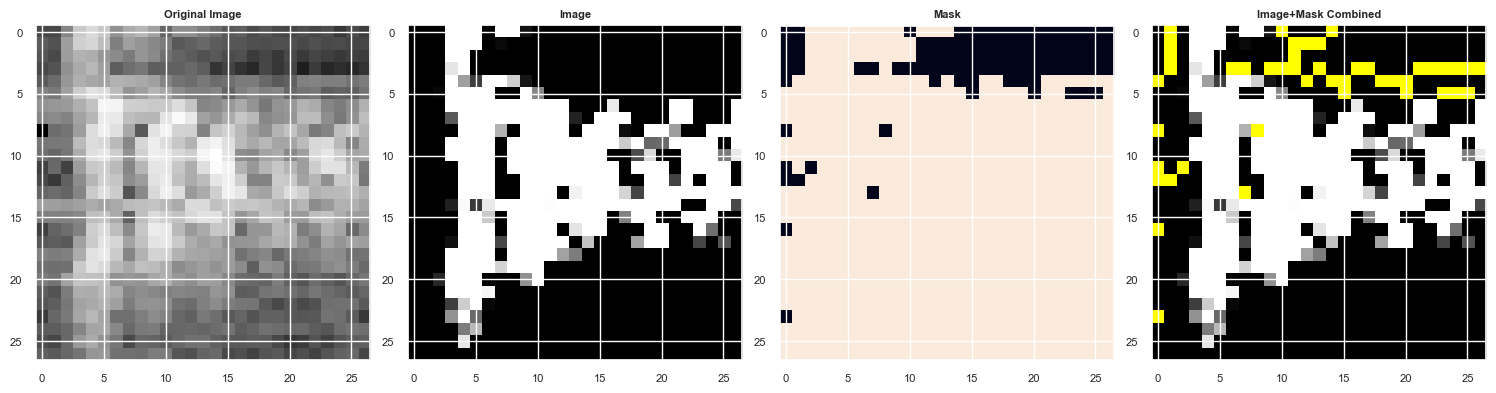

1/1 [==============================] - 0s 8ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: kids talk
Actual: kids talk
Emotion: calm
Emotional Intensity: strong
Sex: F


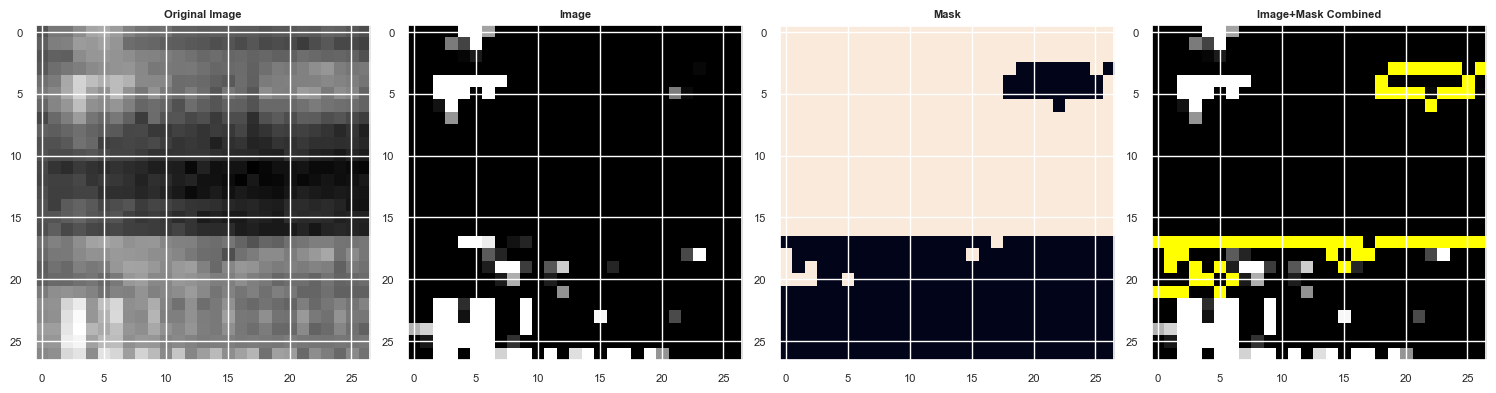

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
Predicted: dogs sit
Actual: dogs sit
Emotion: calm
Emotional Intensity: strong
Sex: F


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


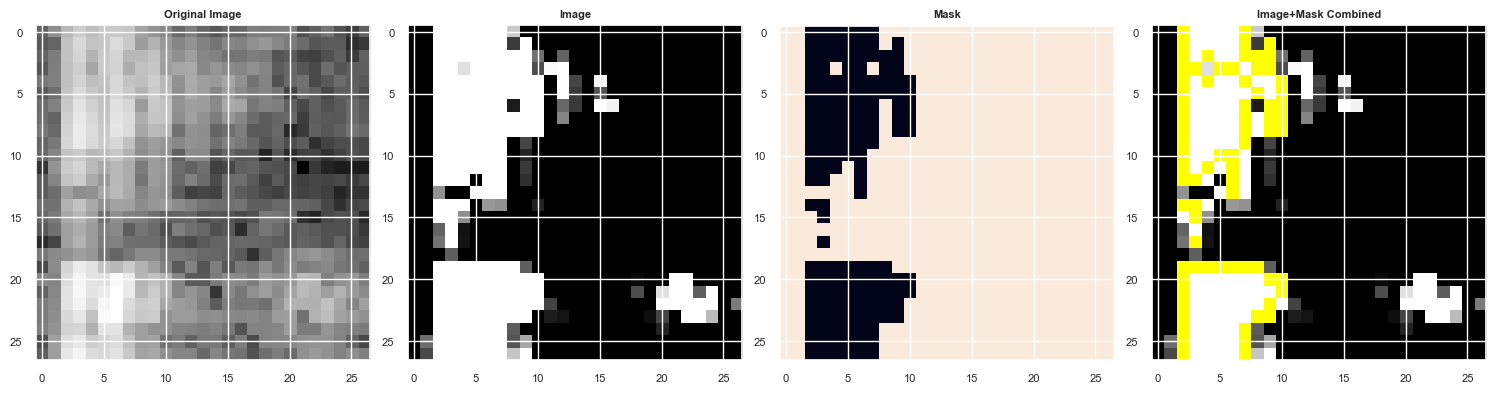

1/1 [==============================] - 0s 8ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: kids talk
Actual: kids talk
Emotion: happy
Emotional Intensity: strong
Sex: F


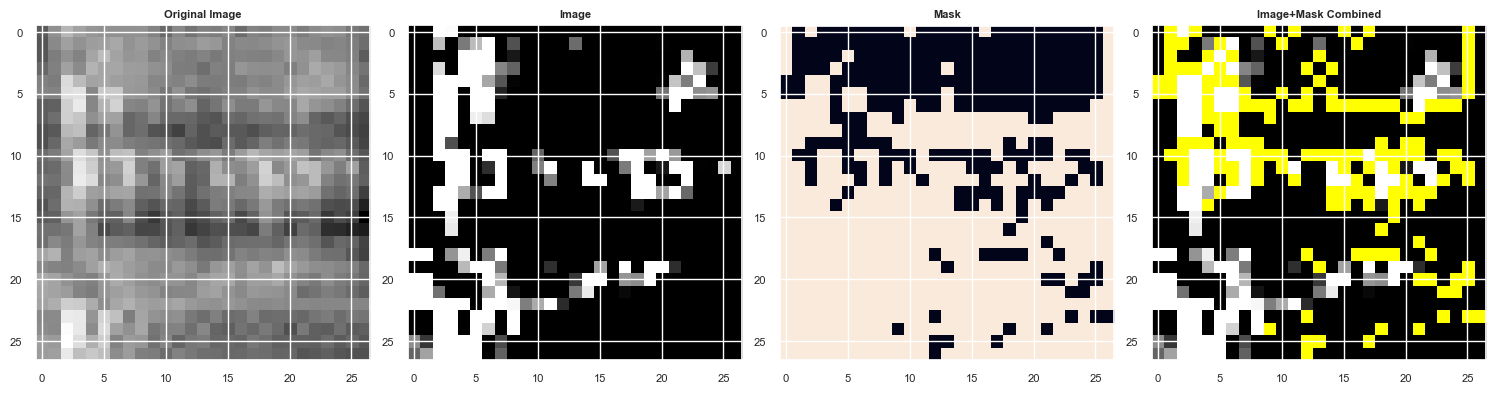

1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: kids talk
Actual: kids talk
Emotion: happy
Emotional Intensity: strong
Sex: F


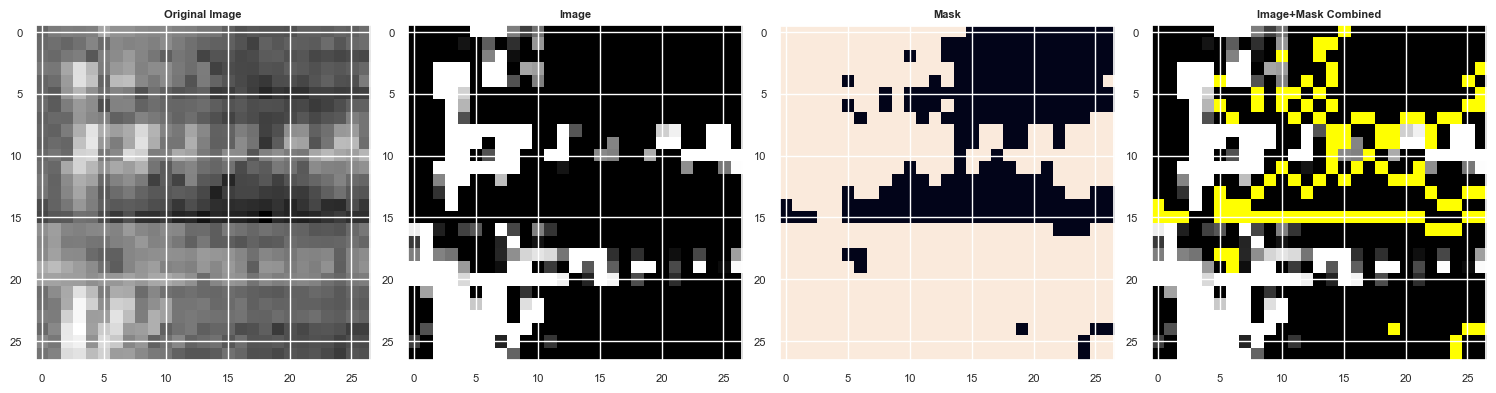

1/1 [==============================] - 0s 8ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: dogs sit
Actual: dogs sit
Emotion: angry
Emotional Intensity: strong
Sex: F


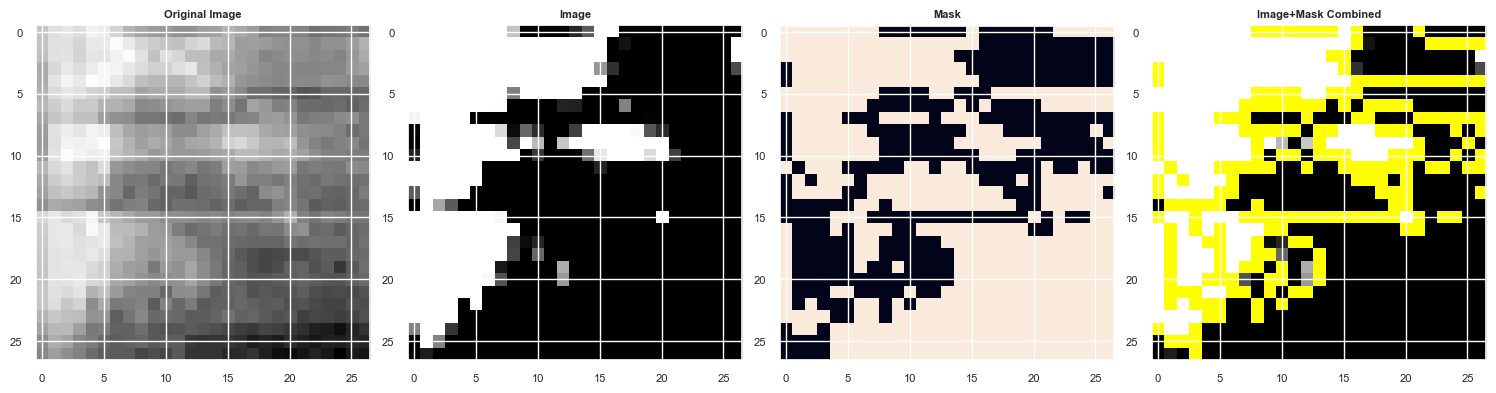

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step
Predicted: kids talk
Actual: kids talk
Emotion: fearful
Emotional Intensity: normal
Sex: F


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


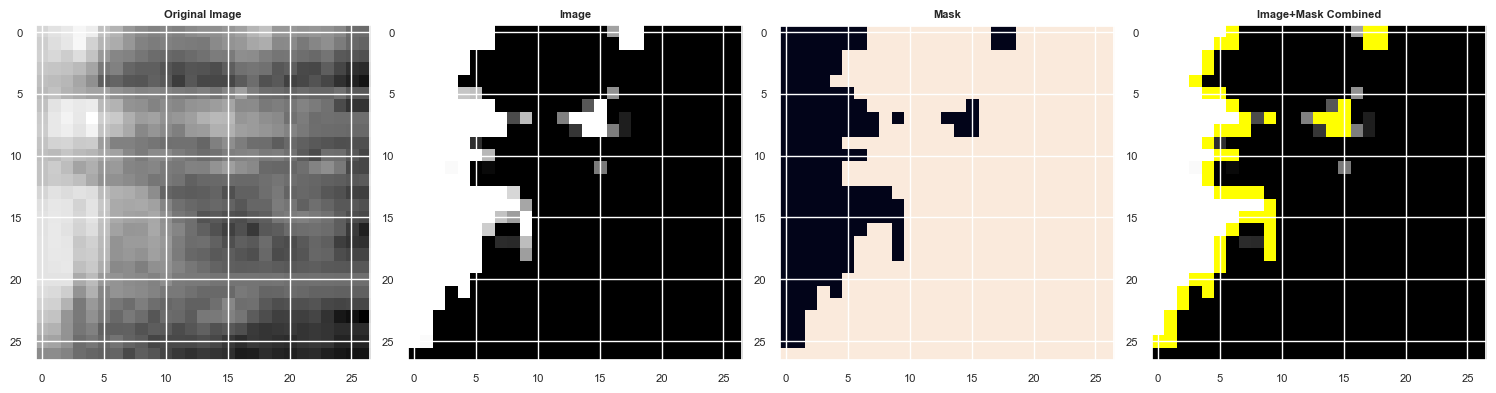

1/1 [==============================] - 0s 9ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step
Predicted: dogs sit
Actual: dogs sit
Emotion: fearful
Emotional Intensity: strong
Sex: F


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


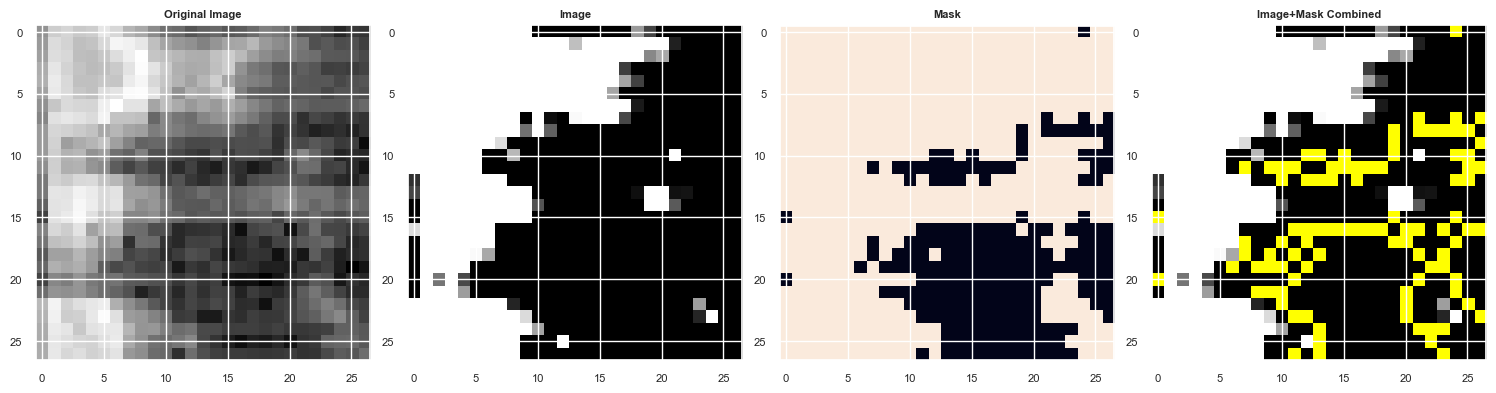

In [28]:
for i in indexes:
    pred = np.argmax(cnn.predict(X_test[i].reshape(-1, 27, 27)))

    explanation = explainer.explain_instance(gray2rgb(X_test[i]), classifier_fn=make_prediction, num_samples=50)
    temp, mask = explanation.get_image_and_mask(pred, num_features=10, hide_rest=False)
    marked_image = mark_boundaries(temp , mask)

    pred_statement = 'dogs sit' if pred == 0 else 'kids talk'
    actual_statement = 'dogs sit' if y_test[i] == 0 else 'kids talk'

    print(f'Predicted: {pred_statement}')
    print(f'Actual: {actual_statement}')
    print(f'Emotion: {df["emotion"][i + len(X_train)]}')
    print(f'Emotional Intensity: {df["emotional_intensity"][i + len(X_train)]}')
    print(f'Sex: {df["sex"][i + len(X_train)]}')

    plot_comparison(X_test[i], gray2rgb(X_test[i]), mask)